This script creates a csv which holds the corresponding validation data points from both Chesapeake Bay Program's (CBP) Water Quality dataset and the two satellite datasets. The csv contains one row for each day and pixel in which there was a CBP validation point, and either a MUR or a Geopolar satellite pixel.

Before running this script, be sure to run:
1. (`01_download_CPBWaterQuality_data.py`) download CBP Water Quality dataset
2. (`.py`) download/access Geopolar
3. (`.py`) download/access MUR

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [10]:
cols = ['EventId', 'Station', 'SampleDate', 'SampleTime', 'Unit',
        'Depth', 'Layer','MeasureValue', 'Latitude', 'Longitude']
wq = pd.read_csv('../../data/raw/delete/WaterQuality_ChesapeakeBayProgram_thru2022.csv', usecols=cols)  # , skipfooter=1)
# wq = wq.drop([521779])  # Remove the empty bottom row
wq['SampleDate'] = pd.to_datetime(wq['SampleDate'], format='%m/%d/%Y')
# # Remove rows before the beginning of the geopolar collection period
# wq = wq[wq['SampleDate'] >= '2002-09-01']
# wq = wq[wq['SampleDate'] <= '2022-03-20']
# # Remove rows that have a null SST value
wq = wq[~wq['MeasureValue'].isnull()]
# Clean the 'Layer' column so there is not trailing whitespace
wq['Layer'] = wq.Layer.str.strip()
# Sort by Date to make life a little easier
wq = wq.sort_values('SampleDate').reset_index(drop=True)

Just noticing that the data stop in June of last year. Maybe the data hasn't been processed? The URL of the request definetly goes through 12-31-2022.

### Quality Checks

In [11]:
# Make sure all values have unit of Celcius
assert len(np.unique(wq.Unit)) == 1
assert np.unique(wq.Unit) == ['DEG C']

In [12]:
wq = wq[wq.MeasureValue < 100]

In [13]:
assert len(wq[wq.MeasureValue > 100]) == 0

**Layer Codes**
from page 33 of [the database schema](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/cbwqdb2004_rb.pdf).
| Code | Meaning|
| :--: | :--: |
| AB | FIXED ABOVE BOTTOM |
| AP | ABOVE PYCNOCLINE |
| B | BOTTOM |
| BP | BELOW PYCNOCLINE |
| BS | FLOATING BELOW SURFACE |
| I | INTEGRATED |
| M | MID-DEPTH |
| M1 | MIDDLE 1/3 OF TOTAL STATION DEPTH |
| M2 | MIDDLE 2/3 OF TOTAL STATION DEPTH |
| S | SURFACE |
| VP | VERTICAL PROFILE |

In [14]:
# Select only samples taken at mid-depths, below the pycnocline, or as part of a vertical profile
wq = wq[(wq.Layer == 'BP') | (wq.Layer == 'M') | (wq.Layer == 'M1') | \
        (wq.Layer == 'M2') | (wq.Layer == 'VP')]

In [15]:
# Filter out anything shallower than 0.2m and deeper than 8m
wq = wq[(wq.Depth > 3) & (wq.Depth < 5)]

### Filtering: Spatial

Learned: All of the "Integrated" profiles are way up in the tributaries. I'm still not sure what it means, but none seem to be in places where we would be trying to compare them to satellite data.

**TODO** Need to move this into the raw data folder

In [16]:
# Open the geometry for the Chesapeake Bay
cbay_shape = gpd.read_file("/Users/rwegener/repos/mhw_ocetrac_census/data/" \
                        "SST-geopolar-chesapeake/cbay_vector.geojson")
cbay_shape = cbay_shape[cbay_shape.DN == 0].iloc[1]

In [17]:
# Convert the dataframe to a spatially-aware geodataframe
wq_gpd = gpd.GeoDataFrame(
    wq, geometry=gpd.points_from_xy(wq['Longitude'], wq['Latitude']), 
    crs='epsg:4326')

In [18]:
%%time
# Runtime: 1.5 minutes

wq = wq_gpd[wq_gpd['geometry'].intersects(cbay_shape.geometry)]
# wq is now a GeoDataFrame

CPU times: user 7.26 s, sys: 36.5 ms, total: 7.29 s
Wall time: 7.34 s


### Filtering: Time

Because we don't have MUR past Jan 2020

In [19]:
wq = wq[(wq.SampleDate >= '2003-01-01') & (wq.SampleDate <= '2019-12-31')]
len(wq)

15945

### Isolating just one depth observation per location

Select one measurement for each location and time, in each case selecting the measurement closest to 2 meters depth.

In [20]:
def find_correct_depth(df):
    if len(df) > 1:
        # Get the row with the depth closest to 2 meters
        df = df.iloc[(df['Depth']-4).abs().argsort()[:1]]
    # if there was only 1 row to begin with, just return that one
    return df

In [21]:
%%time
# Runtime: ~1 minute

wq = wq.groupby(['Station', 'SampleDate', 'SampleTime']) \
                .apply(find_correct_depth)

CPU times: user 17.6 s, sys: 252 ms, total: 17.9 s
Wall time: 18 s


### Inspecting the remaining observations

There are about 39,000 in situ observations ranging from 0.25 to 7.3 meters depth. The majority (>25,000) of them are at about 2m depth. On visual inspection there are not any large regions of the bay that are left totally blank. There is an average of 1953 samples per year with a standard deviation of 535 samples. There are more samples taken in the summer than in the winter.

In [22]:
# wq.geometry.explore()

Text(0.5, 0.98, 'Number of Available Validation Data Points over Time')

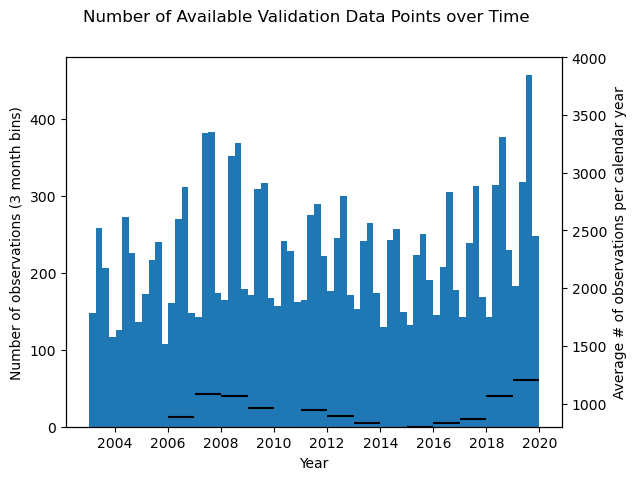

In [23]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylim([800, 4000])

histogram = wq.SampleDate.hist(bins=68, ax=ax1, grid=False)
ax1.set_ylabel('Number of observations (3 month bins)')
ax1.set_xlabel('Year')
# ax1.grid(axis='y', linestyle='--', color='lightgrey')
# ax1.set_yticks(np.arange(100, 900, 100))

# Making the line plot
# didn't work using default pandas .plot(ax=ax2) I think because date range was off
avgs = wq.groupby(wq.SampleDate.dt.year).count().EventId.values
year_start = pd.date_range('2003', '2019', freq='YS')
year_end = pd.date_range('2003', '2020', freq='Y')
ax2.hlines(avgs, year_start, year_end, color='black')
ax2.set_ylabel('Average # of observations per calendar year')
# ax2.set_yticks(np.arange(1200, 3200, 3050))

fig.suptitle('Number of Available Validation Data Points over Time')

# plt.savefig('./figures/validation_analysis/available_validation_hist.png')

## Intersect Operation -- co-locating SST and in situ obs

In [24]:
import warnings

In [25]:
def get_satellite_sst(full_sst, lat, lon, time):
    # print('lat', lat, 'lon', lon, 'time', time)
    # time does NOT have nearest interpolation because we do not want adjacent days to
    # be selected
    try:
        matching_array = full_sst.sel(lat=lat, lon=lon, 
                                      method='nearest').sel(time=time.strftime('%Y-%m-%d')).values
        if matching_array.size == 1:
            matching_sst = matching_array[0]
        elif matching_array.size == 0:
            matching_sst = np.nan
            # warnings.warn('Matching array length is 0. Date is likely missing (?)' + time.strftime('%Y-%m-%d'))
        else:
            raise Exception('more than one matching value?')
    except KeyError:
        # If a key error was raised corresponding date was not found. Return nan for that sample location
        matching_sst = np.nan
    # print('returning ', matching_sst)
    return matching_sst

In [26]:
# wq = wq_applied

In [27]:
wq = wq[['MeasureValue', 'Latitude', 'Longitude', 'SampleDate', 'Depth']]
# wq = wq[['MeasureValue', 'Latitude', 'Longitude', 'Datetime']]
wq_sst = wq.copy()
wq_sst['geopolar_sst'] = -999

In [29]:
# geopolar = xr.open_dataset('/Users/rwegener/repos/mhw_ocetrac_census/data/SST-geopolar-chesapeake/SST_geopolar_chesapeake.nc')
geopolar = xr.open_dataset('/Users/rwegener/repos/chesapeake_mhw/data/raw/delete/L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20030101_20221231.nc')
geopolar = geopolar.analysed_sst

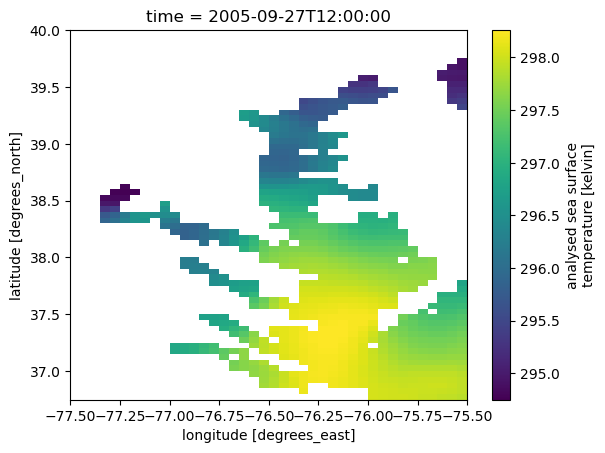

In [30]:
geopolar.isel(time=1000).plot()

In [31]:
wq_sst

MeasureValue  Latitude  Longitude  \
Station     SampleDate SampleTime                                             
1AOCC002.47 2011-06-07 10:10:00   233624         25.90  38.64028  -77.22222   
            2011-11-28 10:20:00   248356         10.60  38.64028  -77.22222   
            2012-07-23 09:45:00   265439         27.18  38.64028  -77.22222   
            2013-12-19 10:10:00   305879          3.78  38.64028  -77.22222   
            2014-06-17 10:15:00   316411         27.09  38.64028  -77.22222   
...                                                ...       ...        ...   
YRK005.40   2013-08-05 07:56:00   294497         25.62  37.24828  -76.49651   
            2013-09-03 07:42:00   297533         25.83  37.24828  -76.49651   
            2013-10-15 07:48:00   300970         19.80  37.24828  -76.49651   
            2015-10-26 07:48:00   353543         16.88  37.24828  -76.49651   
            2017-05-24 07:47:00   392746         20.23  37.24828  -76.49651   

                                         SampleDate  Depth  geopolar_sst  
Station     SampleDate SampleTime                                         
1AOCC002.47 2011-06-07 10:10:00   233624 2011-06-07   3.50          -999  
            2011-11-28 10:20:00   248356 2011-11-28   3.50          -999  
            2012-07-23 09:45:00   265439 2012-07-23   3.50          -999  
            2013-12-19 10:10:00   305879 2013-12-19   3.50          -999  
            2014-06-17 10:15:00   316411 2014-06-17   3.50          -999  
...                                             ...    ...           ...  
YRK005.40   2013-08-05 07:56:00   294497 2013-08-05   3.25          -999  
            2013-09-03 07:42:00   297533 2013-09-03   3.50          -999  
            2013-10-15 07:48:00   300970 2013-10-15   3.25          -999  
            2015-10-26 07:48:00   353543 2015-10-26   3.25          -999  
            2017-05-24 07:47:00   392746 2017-05-24   3.25          -999  

[15217 rows x 6 columns]

Timing Notes

Feb 1: ~22,000 rows: ~50 seconds


In [32]:
%%time

# Create a new column of the wq dataframe containing the corresponding geopolar sst value
wq_sst['geopolar_sst'] = wq_sst.apply(lambda x: get_satellite_sst(geopolar, x.Latitude, x.Longitude, x.SampleDate), 
                                                axis=1)

CPU times: user 24.7 s, sys: 383 ms, total: 25.1 s
Wall time: 25.4 s


In [33]:
len(wq_sst)

15217

In [34]:
wq_sst[~wq_sst.geopolar_sst.isnull()]

MeasureValue  Latitude  Longitude  \
Station     SampleDate SampleTime                                             
1AOCC002.47 2011-06-07 10:10:00   233624         25.90  38.64028  -77.22222   
            2011-11-28 10:20:00   248356         10.60  38.64028  -77.22222   
            2012-07-23 09:45:00   265439         27.18  38.64028  -77.22222   
            2013-12-19 10:10:00   305879          3.78  38.64028  -77.22222   
            2014-06-17 10:15:00   316411         27.09  38.64028  -77.22222   
...                                                ...       ...        ...   
YRK005.40   2013-08-05 07:56:00   294497         25.62  37.24828  -76.49651   
            2013-09-03 07:42:00   297533         25.83  37.24828  -76.49651   
            2013-10-15 07:48:00   300970         19.80  37.24828  -76.49651   
            2015-10-26 07:48:00   353543         16.88  37.24828  -76.49651   
            2017-05-24 07:47:00   392746         20.23  37.24828  -76.49651   

                                         SampleDate  Depth  geopolar_sst  
Station     SampleDate SampleTime                                         
1AOCC002.47 2011-06-07 10:10:00   233624 2011-06-07   3.50    295.989990  
            2011-11-28 10:20:00   248356 2011-11-28   3.50    283.660004  
            2012-07-23 09:45:00   265439 2012-07-23   3.50    299.369995  
            2013-12-19 10:10:00   305879 2013-12-19   3.50    278.769989  
            2014-06-17 10:15:00   316411 2014-06-17   3.50    297.179993  
...                                             ...    ...           ...  
YRK005.40   2013-08-05 07:56:00   294497 2013-08-05   3.25    299.509979  
            2013-09-03 07:42:00   297533 2013-09-03   3.50    299.660004  
            2013-10-15 07:48:00   300970 2013-10-15   3.25    292.880005  
            2015-10-26 07:48:00   353543 2015-10-26   3.25    290.059998  
            2017-05-24 07:47:00   392746 2017-05-24   3.25    293.880005  

[15194 rows x 6 columns]

In [35]:
mur = xr.open_dataset('/Users/rwegener/repos/mhw_ocetrac_census/data/SST-mur-chesapeake-from-skylar/MUR_FullCB.nc')
mur = mur.analysed_sst

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/rwegener/repos/mhw_ocetrac_census/data/SST-mur-chesapeake-from-skylar/MUR_FullCB.nc'

In [ ]:
mur.isel(time=1000).plot()

In [ ]:
%%time

# Create a new column of the wq dataframe containing the corresponding geopolar sst value
wq_sst['mur_sst'] = wq_sst.apply(lambda x: get_satellite_sst(mur, x.Latitude, x.Longitude, x.SampleDate), 
                                                axis=1)

In [ ]:
len(wq_sst)

In [ ]:
wq_sst[~wq_sst.mur_sst.isnull()]

### Cleaning Output

Convert to Celsius

In [37]:
# wq_sst['mur_sst'] = wq_sst['mur_sst'] - 273
wq_sst['geopolar_sst'] = wq_sst['geopolar_sst'] - 273

Keep just the rows where either mur or geopolar have values. (Remove the rows where both mur and geopolar are null)

_Do we want an AND or an OR in there?_ --> OR is good. (note the NOT in front of the isnull)

In [ ]:
wq_sst = wq_sst[(~wq_sst['mur_sst'].isnull()) | (~wq_sst['geopolar_sst'].isnull())]

Optional function / flag -- remove rivers

In [ ]:
wq_sst

In [33]:
wq_sst['Depth'].mean()

4.012962471245482

In [38]:
# droplevel - get rid of SampleDate, because it already exists and 
# also the old index value
wq_sst = wq_sst.droplevel([1, 3]).reset_index()

IndexError: Too many levels: Index has only 1 level, not 2

### Save File

In [35]:
wq_sst.to_csv('../data/AllTemps_WaterQualityMURGeopolar_expD.csv')


### Exploring distribution of depths

In [139]:
june = wq_sst[wq_sst.SampleDate.dt.month == 12]

In [140]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [141]:
t_mean = june.MeasureValue.mean()
t_std = june.MeasureValue.std()
print(t_mean, t_std)

7.915372972972973 2.2980796987571153


In [142]:
gp_mean = june.geopolar_sst.mean()
gp_std = june.geopolar_sst.std()
print(gp_mean, gp_std)

8.525561069797826 1.999455409028514


In [144]:
june.geopolar_sst.max(), june.geopolar_sst.min()

(13.3800048828125, 2.399993896484375)

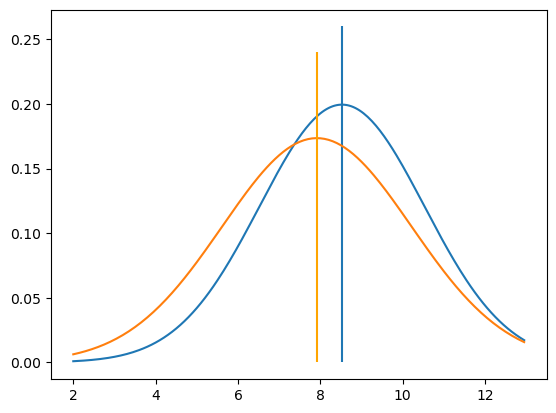

In [146]:
x = np.arange(2, 13, 0.05)

plt.plot(x, norm.pdf(x, gp_mean, gp_std)) 
plt.vlines(gp_mean, 0, 0.26)
plt.plot(x, norm.pdf(x, t_mean, t_std)) 
plt.vlines(t_mean, 0, 0.24, color='orange')

In [131]:
wq_sst

,Station,SampleTime,MeasureValue,Latitude,Longitude,SampleDate,Depth,geopolar_sst
0,1AOCC002.47,10:10:00,25.90,38.64028,-77.22222,2011-06-07,3.50,22.989990
1,1AOCC002.47,10:20:00,10.60,38.64028,-77.22222,2011-11-28,3.50,10.660004
2,1AOCC002.47,09:45:00,27.18,38.64028,-77.22222,2012-07-23,3.50,26.369995
3,1AOCC002.47,10:10:00,3.78,38.64028,-77.22222,2013-12-19,3.50,5.769989
4,1AOCC002.47,10:15:00,27.09,38.64028,-77.22222,2014-06-17,3.50,24.179993
...,...,...,...,...,...,...,...,...
15212,YRK005.40,07:56:00,25.62,37.24828,-76.49651,2013-08-05,3.25,26.509979
15213,YRK005.40,07:42:00,25.83,37.24828,-76.49651,2013-09-03,3.50,26.660004
15214,YRK005.40,07:48:00,19.80,37.24828,-76.49651,2013-10-15,3.25,19.880005
15215,YRK005.40,07:48:00,16.88,37.24828,-76.49651,2015-10-26,3.25,17.059998
